# IUM - Dokumentacja wstępna
Mikołaj Szawerda, Dawid Kaszyński


## Treść zadania
“Gdybyśmy tylko wiedzieli, kiedy użytkownik będzie chciał przesłuchać bieżący utwór w
całości, a kiedy go przewinie – moglibyśmy lepiej zorganizować nasz cache”


## Definicja problemu
Zadanie polega na stworzeniu rozwiązania, które na podstawie dostępnych danych(danych użytkowników, piosenek, autorów, logów sesji) udzieli odpowiedzi, czy użytkownik rozpoczynający odtworzenie danej piosenki przesłucha ją w całości, czy też ją przewinie.
Polecenie zawiera dodatkową informację, mówiącą o celu biznesowym rozwiązania - odpowiedź ma determinować organizację systemu cache.

## Definicja zadania modelowania
Przedstawiony problem jest zadaniem klasyfikacji binarnej. Dla cech pary użytkownik-piosenka należy przyporządkować oczekiwany rezultat interakcji - czy zajdzie zdarzenie przewinięcia.

## Kryteria sukcesu

- Model będzie przewidywał przewinięcia piosenek z dokładnością wynoszącą conajmniej 80%

# Analiza danych

Eksplorując dane oraz badając ich potencjał na rozwiązanie zadania biznesowego musimy uwzględnić kontekst w jakim model będzie wykorzystywany w celu prawidłowego zaprojektowania interfejsu modelu:
- Wyjściem modelu będzie klasyfikacja "tak" (piosenka zostanie przewinięta) lub "nie" (nie zostanie przewinięta).
- Aby dobrze zdefiniować parametry wejściowe modelu należy rozważyć w jakim kontekście biznesowym będzie on wykorzystywany - model będzie odpytywany przed lub w  trakcie uruchomienia danego utworu. Oznacza to, że będzie dostęp do następujących informacji:
    - Kontekst użytkownika: jego preferencje oraz skłonności
    - Kontekst piosenki: jej cechy (np. danceability, acousticness) oraz pośrednio dostęp do gatunków (dzięki informacji o wykonawcy oraz gatunkach w jakich on tworzy)
    - Kontekst obecnej sesji użytkownika - jej czas trwania, interakcje użytkownika z piosenkami (przewinięcia, polubienia) w ramach bieżącej sesji

Pierwsza iteracja modelu będzie zatem opierała się na przewidywaniu wydarzeń przewinięcia piosenki dla trójki (użytkownik, piosenka, sesja), gdzie każde z nich jest reprezentowane poprzez zbiór atrybutów i parametrów je opisujących.

Poniższa analiza zawiera wykaz głównych informacji, które możemy wyciągnąć z danych i wykazują możliwość skonstruowania modelu rozwiązującego zadany problem. Więcej analiz znajduje się w plikach:
- bronze_analyze.ipynb
- silver_sessions.ipynb
- silver_tracks.ipynb
- gold_analyze.ipynb

zawierających obliczenia na różnych poziomach szczegółowości.

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [169]:
users = pd.read_json("data/users.jsonl", lines=True)
sessions = pd.read_json("data/sessions.jsonl", lines=True)

### Użytkownicy

In [170]:
users.head()

,user_id,name,city,street,favourite_genres,premium_user
0,101,Kazimierz Gniewek,Kraków,aleja Liliowa 48/22,"[pop, alternative rock, argentine rock]",False
1,102,Dorota Flisek,Warszawa,pl. Słoneczna 80/07,"[europop, latin rock, post-teen pop]",False
2,103,Anna Maria Bystrek,Warszawa,ul. Turystyczna 334,"[rock, rock en espanol, ranchera]",True
3,104,Bruno Kryszkiewicz,Wrocław,al. Piekarska 738,"[new wave, motown, psychedelic rock]",True
4,105,Melania Frukacz,Gdynia,plac Błękitna 89/97,"[rock en espanol, alternative rock, lounge]",False


<Axes: xlabel='popularity', ylabel='favourite_genres'>

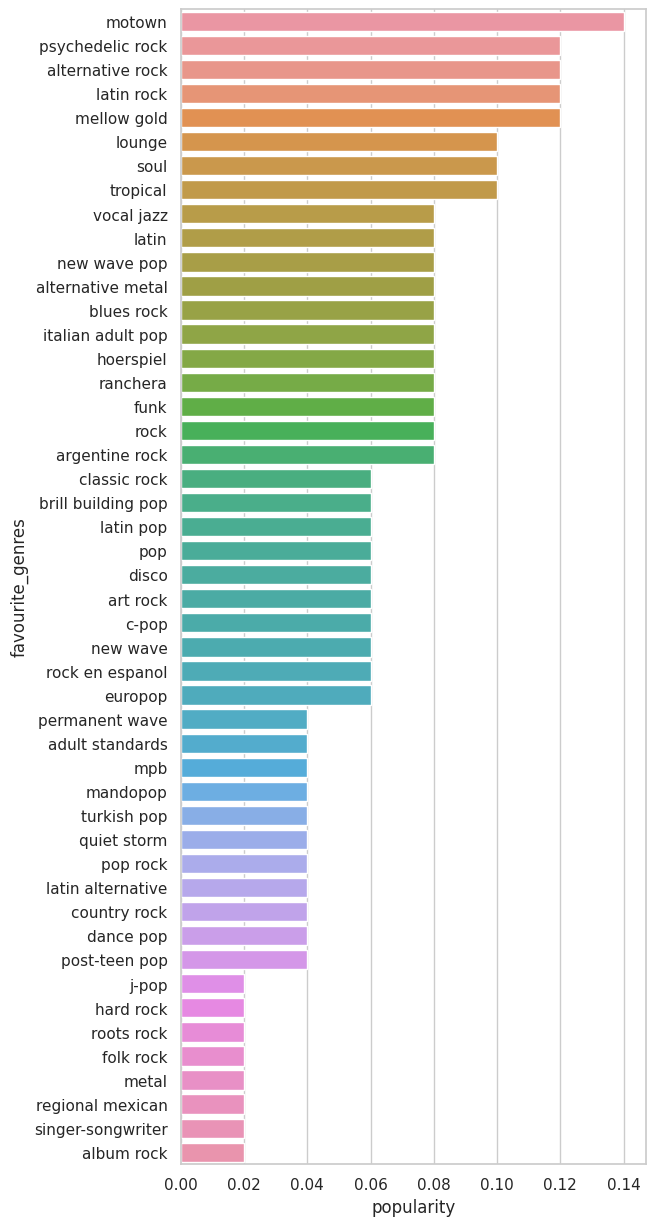

In [171]:
# Popularność gatunków wśród użytkowników
f, ax = plt.subplots(figsize=(6, 15))
genres_popularity = (users.explode("favourite_genres")["favourite_genres"].value_counts() / len(users)).reset_index()
genres_popularity = genres_popularity.rename(columns={"count": "popularity"})

sns.set_color_codes("pastel")
sns.barplot(x="popularity", y="favourite_genres", data=genres_popularity, label="Genres popularity by user")

<Axes: xlabel='city', ylabel='count'>

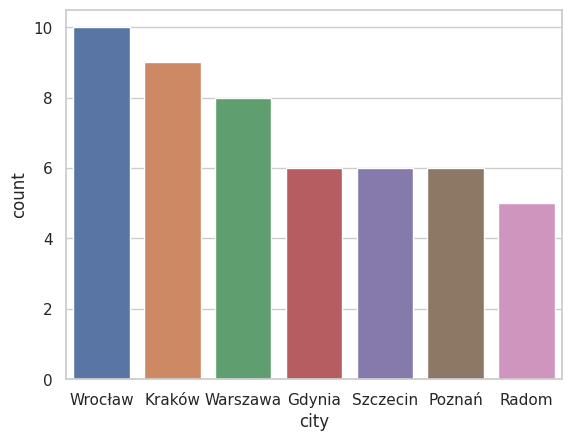

In [172]:
# Miasta użytkowników
cities = users['city'].value_counts().reset_index()
sns.barplot(cities, x="city", y="count")

In [173]:
# Tendencja użytkownika do przewijania piosenek. Informację tę do modelu możemy również uszczegółowić, np. poprzez zbadanie tendencji do przewijania piosenek danego gatunku.

skip_events = sessions[sessions['event_type'] == 'skip'][["user_id", "track_id"]].groupby("user_id").count()
play_events = sessions[sessions['event_type']=='play'][["user_id", "track_id"]].groupby("user_id").count()
user_song_skip_ratio = skip_events / play_events
user_song_skip_ratio.head()

,track_id
user_id,
101,0.121569
102,0.121891
103,0.497653
104,0.876712
105,0.300000


### Piosenki

In [174]:
sns.set_theme(style="whitegrid")
tracks = pd.read_json("data/tracks.jsonl", lines=True).dropna()
tracks.head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,mode,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,7sj6ynHVC4yVa7xJUYoD97,เพียงก่อนนั้น,12,236583,0,5pLJF8oFCs1YpPZaARy1Cz,1986-01-01,0.514,0.272,4,0.0,-14.678,0.0249,0.732000,0.544000,0.1130,0.126,90.077,4
1,7GDczVNdqle26Ff2LrzsLr,עתיד מתוק,27,223800,0,7iE2GZiF0xVFzlA2E93m3g,1985-11-01,0.654,0.842,4,0.0,-7.279,0.0360,0.381000,0.011300,0.1300,0.765,142.966,4
2,4AyUgUtX0nMsBjzZFDWVgM,スピード,28,287831,0,2DiecQcRbDuSJuSPKtirrX,1991-02-21,0.452,0.961,9,1.0,-3.379,0.0704,0.083100,0.000322,0.0851,0.468,132.790,4
3,4gxYRhp7DeB11eC5VQOJ7w,Wir ham' noch lange nicht genug,57,292000,0,6x9jRPDmA8Ihpw3A9FBowD,1991,0.555,0.722,0,1.0,-11.298,0.0271,0.000767,0.000027,0.0813,0.659,148.105,4
4,78Eqonqp6yxXuYQtnffk0W,Faço Como,43,201253,0,7gsMzXapXdZ5XzVPJp4rBd,2018-05-19,0.715,0.402,0,0.0,-11.527,0.1490,0.350000,0.345000,0.1060,0.246,183.948,4


<Axes: >

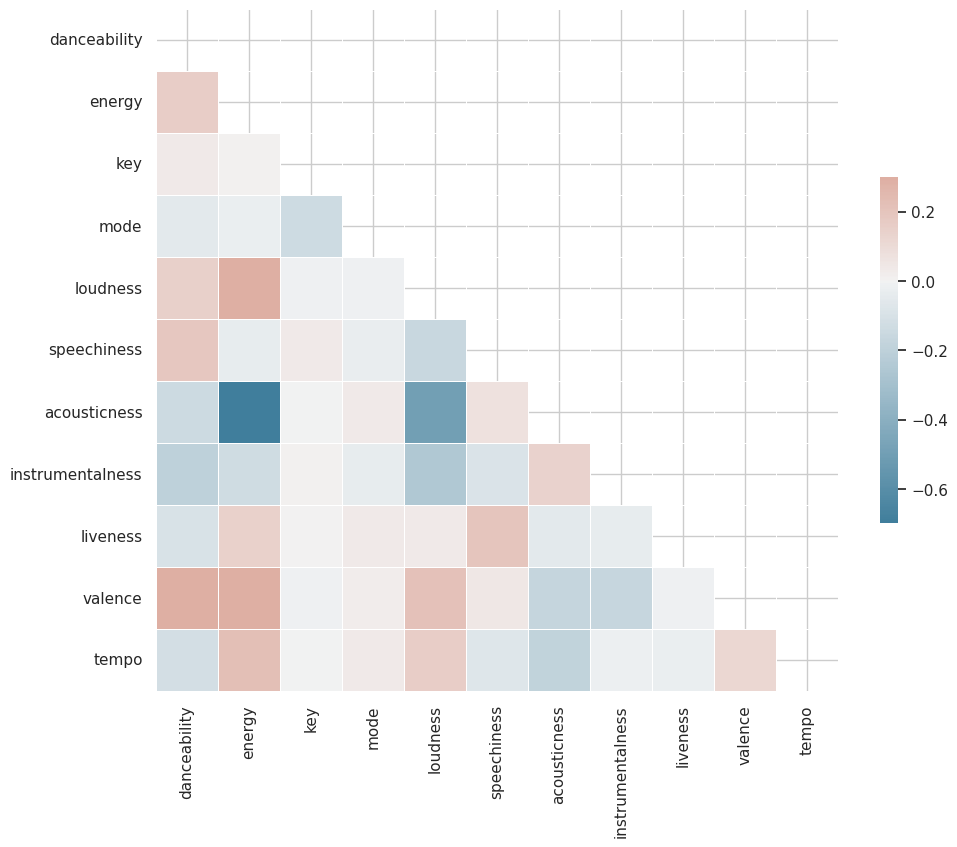

In [175]:
# Korelacja parametrów piosenek
corr = tracks.iloc[:,7:-1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [176]:
artists = pd.read_json("data/artists.jsonl", lines=True)
artists.head()

,id,name,genres
0,7b6Ui7JVaBDEfZB9k6nHL0,The Local Train,"[desi pop, hindi indie, indian indie, indian r..."
1,4gdMJYnopf2nEUcanAwstx,Anuv Jain,"[hindi indie, indian indie, indian singer-song..."
2,6AETRCQep85mUtIlX7BaFV,Color Humano,"[argentine rock, rock nacional]"
3,2qnTUTsuypizIuMwVM1ffR,Los Hermanos Cardozo,"[chamame, folklore argentino]"
4,1wELOF6Lb5TckxS5EiiQZe,Don Cornelio Y La Zona,"[argentine indie, argentine rock, post-punk ar..."


In [177]:
# Piosenki a możliwe gatunki bazując na gatunkach, w których nagrywa dany artysta
tracks = tracks.merge(artists, left_on='id_artist', right_on='id')[["name_x", "name_y", "genres"]]
tracks = tracks.rename(columns={"name_x": "song_name", "name_y": "artist_name", "genres": "possible_genres"})
tracks.head()

,song_name,artist_name,possible_genres
0,เพียงก่อนนั้น,คีรีบูน,[classic thai pop]
1,עתיד מתוק,Mashina,"[classic israeli pop, israeli rock]"
2,בן המלך,Mashina,"[classic israeli pop, israeli rock]"
3,תתעורר,Mashina,"[classic israeli pop, israeli rock]"
4,スピード,BUCK-TICK,"[j-metal, j-rock, japanese new wave, visual kei]"


### Sesje

In [178]:
sessions.head()

,timestamp,user_id,track_id,event_type,session_id
0,2023-01-02 05:58:46.000,101,0jNxo9JcSNcyrYW6AIJhIz,play,124
1,2023-01-02 06:04:59.656,101,0jNxo9JcSNcyrYW6AIJhIz,like,124
2,2023-01-02 06:06:03.813,101,3xfmdZVopiPhbqENrH1XOL,play,124
3,2023-01-02 06:07:45.225,101,3xfmdZVopiPhbqENrH1XOL,like,124
4,2023-01-02 06:08:00.920,101,59m93IlJ9N9dOjAZIm9NzY,play,124


In [179]:
# Czas trwania sesji
sessions.reset_index().groupby(['session_id', 'user_id']).agg(session_start=('timestamp', 'min'), session_end=('timestamp', 'max')).assign(duration=lambda x: x['session_end'] - x['session_start']).reset_index()

,session_id,user_id,session_start,session_end,duration
0,124,101,2023-01-02 05:58:46,2023-01-02 06:48:07.124,0 days 00:49:21.124000
1,125,101,2023-01-09 13:30:57,2023-01-09 14:59:27.143,0 days 01:28:30.143000
2,126,101,2023-01-12 19:26:08,2023-01-12 21:33:19.203,0 days 02:07:11.203000
3,127,101,2023-01-19 21:04:36,2023-01-19 23:43:01.328,0 days 02:38:25.328000
4,128,101,2023-02-01 22:09:05,2023-02-01 23:34:37.991,0 days 01:25:32.991000
...,...,...,...,...,...
643,816,150,2023-09-01 08:44:48,2023-09-01 09:28:18.075,0 days 00:43:30.075000
644,817,150,2023-09-03 16:15:06,2023-09-03 16:35:12.331,0 days 00:20:06.331000
645,818,150,2023-09-23 23:05:26,2023-09-24 00:07:13.194,0 days 01:01:47.194000
646,819,150,2023-10-17 12:01:53,2023-10-17 12:59:34.612,0 days 00:57:41.612000


In [180]:
# Wykaz eventów związanych z daną piosenką - jak często jest przewijana i odtwarzana. Zamieniając konkretną piosenkę na zbiór jej cech możemy wyciągać wnioski o popularności utworu danego typu czy też tendencji do jego przewijania (w szczególności rozszerzając informację o to, czym charakteryzuje się użytkownik, który daną piosenkę przewinął
tracks_events = sessions[~sessions.event_type.isin(["advertisement", "buy_premium"])][["track_id", "event_type", "timestamp"]]\
    .groupby(["track_id", "event_type"]).count().rename(columns={"timestamp": "occurences"})
tracks_events.head()

occurences
track_id               event_type            
0055LRFB7zfdCXDGodyIz3 play                 1
                       skip                 1
008kBr70Aei9vj2ohMQNqb like                 1
                       play                 2
                       skip                 2